In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

2025-07-29 07:39:20.562388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753799960.764145 1829391 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753799960.814548 1829391 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753799961.217774 1829391 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753799961.217798 1829391 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753799961.217801 1829391 computation_placer.cc:177] computation placer alr

In [2]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)




(64, 64, 64)


In [3]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [4]:
def generate_single_2d_density(ref_d, noise_level):
    noisy_3d = stochastic_density(ref_d, noise_level)  # shape: (64, 64, 64)
    return noisy_3d

# Noise levels to randomly draw from
noise_levels = [10000 * (j + 1) for j in range(5)]  # [10000, 20000, ..., 50000]

# Sizes
num_train = 5000
num_val = 1000
num_test = 500

# Generate train set with mixed noise levels
x_train = np.zeros((num_train, 64, 64,64))
for i in range(num_train):
    noise_level = np.random.choice(noise_levels)
    x_train[i] = generate_single_2d_density(ref_d, noise_level)

# Generate val set with mixed noise levels
x_val = np.zeros((num_val, 64, 64,64))
for i in range(num_val):
    noise_level = np.random.choice(noise_levels)
    x_val[i] = generate_single_2d_density(ref_d, noise_level)



print("Train, val, generated")


Train, val, generated


In [5]:
# Generate test set with fixed noise level
x_test = np.zeros((num_test, 64, 64, 64))
for i in range(num_test):
    x_test[i] = generate_single_2d_density(ref_d, 100000)
print("test generated")

test generated


In [6]:
y_test_3d = np.zeros((x_test.shape[0],64,64,64))
y_train_3d = np.zeros((x_train.shape[0],64,64,64))
y_val_3d = np.zeros((x_val.shape[0],64,64,64))
for i in range (y_test_3d.shape[0]):
    y_test_3d[i]=stochastic_density(ref_d,1000000)
y_test = y_test_3d
for i in range (y_train_3d.shape[0]):
    y_train_3d[i]=stochastic_density(ref_d,1000000)
y_train = y_train_3d

for i in range (y_val_3d.shape[0]):
    y_val_3d[i]=stochastic_density(ref_d,1000000)
y_val = y_val_3d
print("here")

here


In [7]:
import numpy as np

def batch_project_3d_to_rgb(x_train_3d, x_val_3d, x_test_3d,
                            y_train_3d, y_val_3d, y_test_3d,
                            buffer_scale=1.01):
    """
    Projects all input and output 3D densities to 2D RGB with per-sample normalization.

    Args:
        x_train_3d, x_val_3d, x_test_3d, y_train_3d, y_val_3d, y_test_3d: ndarray of shape (N, H, W, D)
        buffer_scale: float, buffer for normalization (default 1.01)

    Returns:
        Tuple of normalized RGB arrays in order:
        x_train_rgb, x_val_rgb, x_test_rgb,
        y_train_rgb, y_val_rgb, y_test_rgb
    """
    def split_sum_rgb(x_3d):
        N, H, W, D = x_3d.shape
        thirds = np.array_split(np.arange(D), 3)
        r = np.sum(x_3d[:, :, :, thirds[0]], axis=-1)
        g = np.sum(x_3d[:, :, :, thirds[1]], axis=-1)
        b = np.sum(x_3d[:, :, :, thirds[2]], axis=-1)
        return np.stack([r, g, b], axis=-1)

    def normalize_per_sample(x_rgb):
        # Compute per-sample max
        max_vals = np.max(x_rgb, axis=(1, 2, 3), keepdims=True)
        max_vals = np.where(max_vals == 0, 1.0, max_vals)  # Prevent div by zero
        return np.clip(x_rgb / (max_vals * buffer_scale), 0, 1)

    # Convert to RGB
    x_train_rgb = normalize_per_sample(split_sum_rgb(x_train_3d))
    x_val_rgb   = normalize_per_sample(split_sum_rgb(x_val_3d))
    x_test_rgb  = normalize_per_sample(split_sum_rgb(x_test_3d))
    y_train_rgb = normalize_per_sample(split_sum_rgb(y_train_3d))
    y_val_rgb   = normalize_per_sample(split_sum_rgb(y_val_3d))
    y_test_rgb  = normalize_per_sample(split_sum_rgb(y_test_3d))

    return (
        x_train_rgb, x_val_rgb, x_test_rgb,
        y_train_rgb, y_val_rgb, y_test_rgb
    )


I0000 00:00:1753800212.984186 1829391 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
I0000 00:00:1753800212.986912 1829391 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38366 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
I0000 00:00:1753800212.989816 1829391 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38366 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:82:00.0, compute capability: 8.0
I0000 00:00:1753800212.991541 1829391 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38366 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


Epoch 1/50


I0000 00:00:1753800216.078037 1830851 service.cc:152] XLA service 0x7f35800116e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753800216.078061 1830851 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1753800216.078065 1830851 service.cc:160]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1753800216.078069 1830851 service.cc:160]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
I0000 00:00:1753800216.078071 1830851 service.cc:160]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-07-29 07:43:36.198700: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753800216.568871 1830851 cuda_dnn.cc:529] Loaded cuDNN version 90300


 40/157 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2386  

I0000 00:00:1753800219.884693 1830851 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - loss: 0.1664 - val_loss: 0.0382 - learning_rate: 1.0000e-04
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0319 - val_loss: 0.0226 - learning_rate: 1.0000e-04
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0214 - val_loss: 0.0184 - learning_rate: 1.0000e-04
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0176 - val_loss: 0.0168 - learning_rate: 1.0000e-04
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0159 - val_loss: 0.0149 - learning_rate: 1.0000e-04
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0147 - val_loss: 0.0140 - learning_rate: 1.0000e-04
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0140 - val_loss: 0.0135 - learning_rate: 1.0000e-04
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0133 - val_loss: 0.0129 - learning_rate: 1.0000e-04
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0128 - val_loss: 0.0134 - learning_

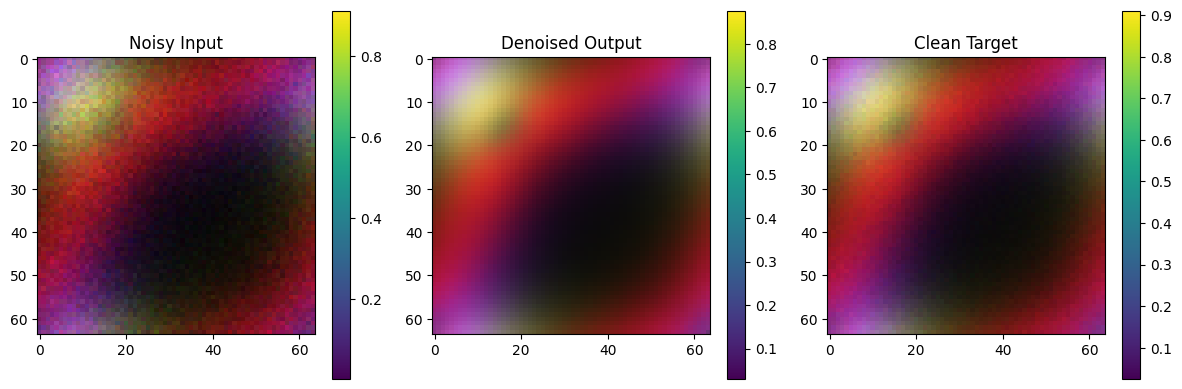

In [8]:
x_train_rgb, x_val_rgb, x_test_rgb, y_train_rgb, y_val_rgb, y_test_rgb = batch_project_3d_to_rgb(
    x_train, x_val, x_test,
    y_train_3d, y_val_3d, y_test_3d,
    buffer_scale=1.10
)
#Try learning rate scheduler
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import matplotlib.pyplot as plt


def renormalize_sum_to_eight(x):
    total = tf.reduce_sum(x, axis=[1, 2, 3], keepdims=True)
    print(total)
    return x / (total + 1e-8) * 8.0

# --- Jensen-Shannon Divergence Loss ---
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)
    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)
    return tf.reduce_mean(0.5 * (kl_true + kl_pred))

# --- 3D CAE Model Definition ---
def create_simple_2d_cae(input_shape=(64, 64, 3), dropout_rate=0.2, l2_strength=1e-8):
    reg = regularizers.l2(l2_strength)
    input_layer = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Bottleneck
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=reg)(x)


    output_layer =  layers.Conv2D(3, (3, 3),  activation='relu', padding='same')(x)

    #output_layer = layers.Lambda(renormalize_sum_to_eight)(x)

    return models.Model(inputs=input_layer, outputs=output_layer)




# --- Training Pipeline ---
if __name__ == '__main__':
    # Assume x_train_3d, y_train_3d, etc. are already loaded
    # Add channel dim: (64,64,64) → (64,64,64,1)

    input_shape = (64, 64, 3)
    cae = create_simple_2d_cae(input_shape)
    cae.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mae')

    # Callbacks
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)
    callbacks_list = [early_stop, lr_scheduler]

    # Train
    cae.fit(x_train_rgb, y_train_rgb,
        validation_data=(x_val_rgb, y_val_rgb),
        epochs=50,
        batch_size=32,
        callbacks=callbacks_list,
        verbose=1)

    # Predict one test volume
    i = 0
    denoised = cae.predict(x_test_rgb[i:i+1])[0]
    noisy_input = x_test_rgb[i]
    true_clean = y_test_rgb[i]
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(noisy_input)
    plt.title("Noisy Input")
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.imshow(denoised)
    plt.title("Denoised Output")
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    plt.imshow(true_clean)
    plt.title("Clean Target")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()



In [9]:
# --- Evaluation on the Test Set ---
print(">>> Testing on the projected RGB test set")
print(x_test_rgb.shape, "Shape of test set")

# Average prediction (mean image)
test_avg = np.mean(x_test_rgb, axis=0)
print(test_avg.shape, "Shape of average of test set")
ref_d = y_test_rgb[0]  # Choose a representative DFT reference
print(ref_d.shape, "Reference shape (should be (64, 64, 3))")

# --- 2-Norm Difference ---
print("2-norm difference")
print("Mean vs DFT 2-norm diff:")
print(np.linalg.norm(test_avg - ref_d))

# --- Prediction vs Reference ---
print("\nPrediction of one test sample vs DFT")
print(x_test_rgb[0:1].shape, "Test sample shape")

# Predict denoised image
pred = cae.predict(x_test_rgb[0:1])[0]
print(pred.shape, "Prediction shape", ref_d.shape)
print("2-norm(pred vs DFT):", np.linalg.norm(pred - ref_d))

# --- Jensen-Shannon Divergence Analysis ---
print("\nDivergence differences")

# Predict mean of test set passed through model
mean_pred = cae.predict(test_avg.reshape(1, 64, 64, 3))[0]

print("JSD(bar{x_test}, y_dft):", jensen_shannon_divergence_loss(test_avg, ref_d.copy()).numpy())
print("JSD(DAE(bar{x}), y_dft):", jensen_shannon_divergence_loss(mean_pred, ref_d.copy()).numpy())
print("JSD(DAE(x_i), y_dft):", jensen_shannon_divergence_loss(pred, ref_d.copy()).numpy())


>>> Testing on the projected RGB test set
(500, 64, 64, 3) Shape of test set
(64, 64, 3) Shape of average of test set
(64, 64, 3) Reference shape (should be (64, 64, 3))
2-norm difference
Mean vs DFT 2-norm diff:
3.643556697589657

Prediction of one test sample vs DFT
(1, 64, 64, 3) Test sample shape
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
(64, 64, 3) Prediction shape (64, 64, 3)
2-norm(pred vs DFT): 1.2662035129009033

Divergence differences
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
JSD(bar{x_test}, y_dft): 0.00022448655
JSD(DAE(bar{x}), y_dft): 0.00030121914
JSD(DAE(x_i), y_dft): 0.00025924924


In [10]:
def normalize_to_electron_count(x, target_sum=8.0):
    # Avoid division by zero
    current_sum = np.sum(x, axis=(1, 2, 3), keepdims=True)
    current_sum[current_sum == 0] = 1.0
    return x * (target_sum / current_sum)

# Normalize test set and reference to have total sum = 8
x_test_norm = normalize_to_electron_count(x_test_rgb.copy(), target_sum=8.0)
ref_d_norm = ref_d.copy() * (8.0 / np.sum(ref_d))

# --- Average prediction (mean image) ---
test_avg = np.mean(x_test_norm, axis=0)
print("Shape of test set:", x_test_norm.shape)
print("Shape of average of test set:", test_avg.shape)
print("Shape of reference:", ref_d_norm.shape)

# --- 2-Norm Difference ---
print("\n2-norm difference")
print("Mean vs DFT 2-norm diff:", np.linalg.norm(test_avg - ref_d_norm))

# --- Prediction vs Reference ---
print("\nPrediction of one test sample vs DFT")
pred = cae.predict(x_test_norm[0:1])[0]
print("Prediction shape:", pred.shape)

# Normalize prediction
pred_norm = pred * (8.0 / np.sum(pred))

print("2-norm(pred, ref_d):", np.linalg.norm(pred_norm - ref_d_norm))

# --- Jensen-Shannon Divergence Analysis ---
print("\nJensen-Shannon Divergence")

mean_pred = cae.predict(test_avg.reshape(1, 64, 64, 3))[0]
mean_pred_norm = mean_pred * (8.0 / np.sum(mean_pred))

print("JSD(bar{x_test}, y_dft):", jensen_shannon_divergence_loss(test_avg, ref_d_norm).numpy())
print("JSD(DAE(bar{x}), y_dft):", jensen_shannon_divergence_loss(mean_pred_norm, ref_d_norm).numpy())
print("JSD(DAE(x_i), y_dft):", jensen_shannon_divergence_loss(pred_norm, ref_d_norm).numpy())


Shape of test set: (500, 64, 64, 3)
Shape of average of test set: (64, 64, 3)
Shape of reference: (64, 64, 3)

2-norm difference
Mean vs DFT 2-norm diff: 0.002845904719964131

Prediction of one test sample vs DFT
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Prediction shape: (64, 64, 3)
2-norm(pred, ref_d): 0.04304542637968422

Jensen-Shannon Divergence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
JSD(bar{x_test}, y_dft): 0.0002244806
JSD(DAE(bar{x}), y_dft): 0.037051693
JSD(DAE(x_i), y_dft): 0.037044957


In [12]:
cae.save("CAE.keras")